In [1]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>")) # Increase cell width
display(HTML("<style>.rendered_html { font-size: 16px; }</style>")) # Increase font size

import warnings
warnings.filterwarnings('ignore') # Do not print warning messages

In [2]:
# Larger figures

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

# Introduction

In this first practical session we will make the first contact with the featuring engineering process and its impact in a ML pipeline.
Feature engineering is one of the most important step of the process of developing prediction models. It is considered, by many authors, an art, and it involves human-driven design and intuition. This practice will try to uncover the most relevant issues that must be addressed, and also provide some guidelines to start building sound feature engineering processes for ML problems. 

The experimental dataset we are going to use is the HR Analytics Dataset. It includes explanatory variables of around 15k employees of a large company. The goal of the case study is to
model the probability of attrition (employees leaving, either on their own or because they got fired) of each employee, as well as to understand which variables are the most important ones and need to be addressed right away.

The results obtained will be helpful for the management in order to understand what changes they should make to their workplace to get most of their employees to stay.

For more details on the dataset and the task see: <https://www.kaggle.com/manojvijayan/feature-engineering-for-logistic-regression>.

# Data Loading and Pre-Processing

Let's load the dataset to make sense of the information we have about the employees.

In [3]:
import pandas as pd
import numpy as np
import sklearn

In [4]:
initial_hr_df = pd.read_csv("data/turnover.csv")
initial_hr_df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [5]:
# Keep the original dataset for later comparisons and make a copy for the FE process
hr_df = initial_hr_df

We have 10 columns: the target variable (`left`) and 9 more features to work with. Let's analyze a little bit more each of them to check if we need to clean or preprocess them.

At this point I want to provide you with a very handful library to analyze your datasets: `pandas_profiling` (for more information and how to install it, check the official documentation: https://pandas-profiling.github.io/pandas-profiling/docs/). This library will analyze your dataset, taking into account the different aspects you usually want to inspect, and it will create a report that I find very useful to: 1) better understand your data and inform your ML pipeline and 2) to create a visual dataset summary that can be included in your final report.

In [6]:
from pandas_profiling import ProfileReport
report = ProfileReport(hr_df, minimal=False)
report

Summarize dataset:   0%|          | 0/23 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Factorize Features

2 of the categories (`sales` and `salary`) are categorical. In addition, if we analyze the rest of the features we will see that we have three more categorical values encoded as numeric: `Work_accident`, `promotion_last_5years` and the target variable itself (`left`). Therefore, we should convert them to categorical before any further processing.

You can use the `astype` function for the conversion.

In [7]:
hr_df.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
sales                     object
salary                    object
dtype: object

In [8]:
hr_df['sales'] = hr_df.sales.astype('category')
hr_df['salary'] = hr_df.salary.astype('category')
hr_df['promotion_last_5years'] = hr_df.promotion_last_5years.astype('category')
hr_df['left'] = hr_df.left.astype('category')
hr_df['Work_accident'] = hr_df.Work_accident.astype('category')

hr_df.dtypes

satisfaction_level        float64
last_evaluation           float64
number_project              int64
average_montly_hours        int64
time_spend_company          int64
Work_accident            category
left                     category
promotion_last_5years    category
sales                    category
salary                   category
dtype: object

### Advanced Factorization

The rest of the numerical values present a level of detail that may be much more fine-grained than we need. For instance, the satisfaction level can be represented by different categories (low, medium, high, ...). We will then create another "bucketized" feature for each of the numerical columns.


In [9]:
hr_df['satisfaction_level_bin'] = pd.cut(hr_df['satisfaction_level'], bins=[0, 0.11, 0.35, 0.46, 0.71, 0.92,1.0], labels=[0,1,2,3,4,5]).astype('int64')
hr_df['last_evaluation_bin'] = pd.cut(hr_df['last_evaluation'], bins=[0, 0.47, 0.48, 0.65, 0.88, 0.89,1.0], labels=[0,1,2,3,4,5]).astype('int64')


In [10]:
hr_df['number_project_cat'] = hr_df['number_project'].map({2:"Low",3:"Low",4:"Medium",5:"Medium",6:"High",7:"Very_High"}).astype('category')
hr_df['time_spend_company_cat'] = hr_df['time_spend_company'].map({2:"Low",3:"Medium",4:"Medium",5:"Medium",6:"High",7:"High",8:"Very_High",10:"Very_High"}).astype('category')

## Hunting NAs

There is not any NULL values, so we can skip this step. You can see by summarizing the dataset or you can use the `isnull` function to identify the null values.

In [11]:
hr_df.isnull().sum()

satisfaction_level        0
last_evaluation           0
number_project            0
average_montly_hours      0
time_spend_company        0
Work_accident             0
left                      0
promotion_last_5years     0
sales                     0
salary                    0
satisfaction_level_bin    0
last_evaluation_bin       0
number_project_cat        0
time_spend_company_cat    0
dtype: int64

It is unlikely not to have any null values in the dataset (this is a reduced and rather clean dataset of the original one). In the case that you have null values, you should follow some of the imputation/removal strategies explained in class. Although `sklearn` (and some other libraries) provides ways to impute/remove the null values while training your model, I strongly recommend you to do it by yourself to control the process.


## Outlier Analysis

Another aspect that may affect the performance of our machine learning pipeline is the presence of outliers. We will focus on the numerical columns of the dataset to detect the presence of outliers and proceed to their removal.

The easiest way to detect outliers is visualizing the numerical values; for instance, by `boxploting` the column values.

For instance, if we plot the `time_spend_company` feature, we will see that there are some extreme cases of employees that have spent many years at the company. 

<AxesSubplot:>

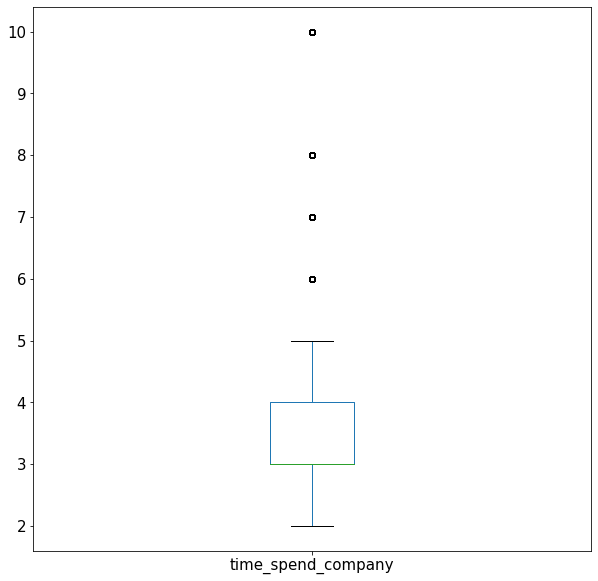

In [12]:
plt.figure(figsize=(10,10))
hr_df.boxplot(['time_spend_company'], grid=False, fontsize=15)


We don't want these extreme cases to affect or bias the training process, so the best is to remove them.
We can apply some metric (i.e., the Z-score) to detect and remove these points. Pandas provides a `quantile` function to compute the different quantiles and to remove the outliers based on them:

In [13]:
# See https://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm
    
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    print("{} outliers removed".format(len(df_in)-len(df_out)))
    return df_out

In [14]:
hr_df = remove_outlier(hr_df,'time_spend_company')

1282 outliers removed


Let's do the same for the rest of the columns.

Analyzing outliers of column: satisfaction_level
0 outliers removed


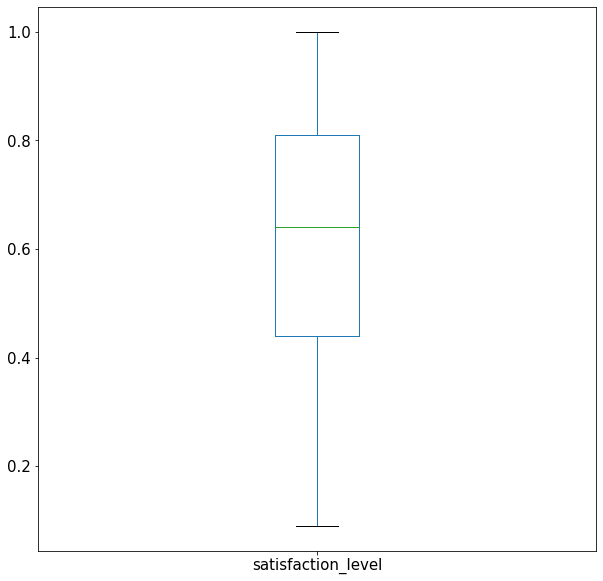

Analyzing outliers of column: last_evaluation
0 outliers removed


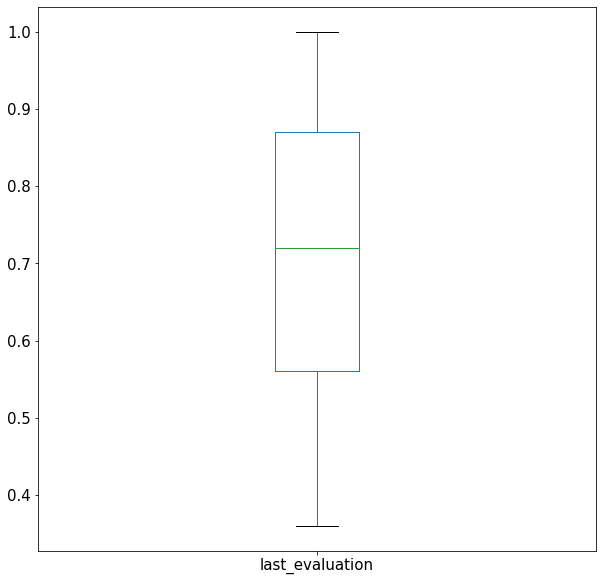

Analyzing outliers of column: number_project
0 outliers removed


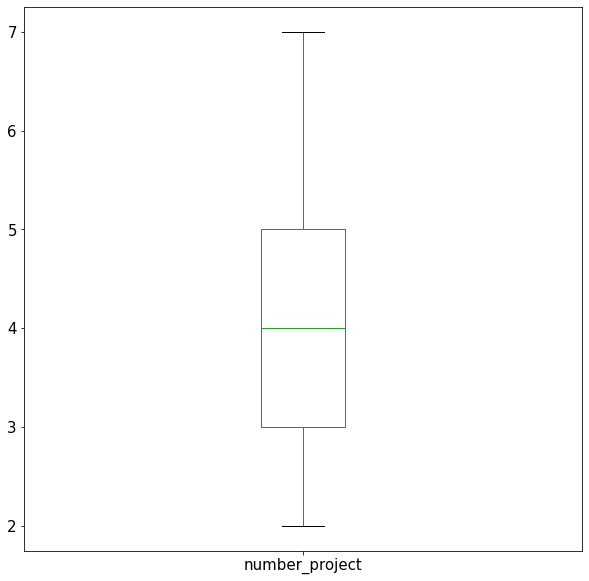

Analyzing outliers of column: average_montly_hours
0 outliers removed


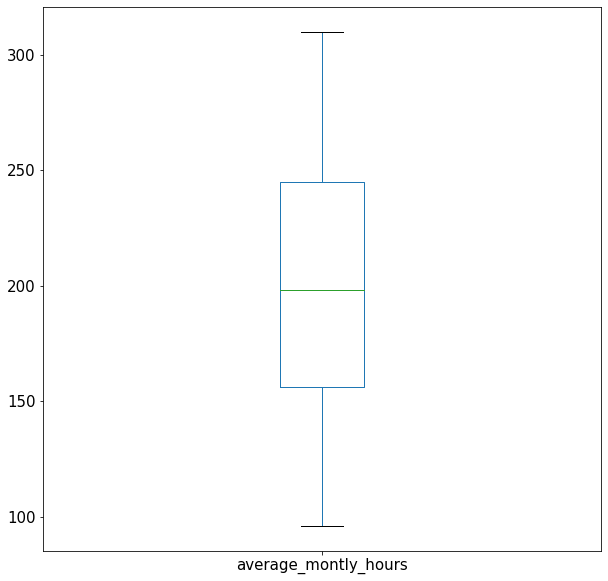

Analyzing outliers of column: time_spend_company
0 outliers removed


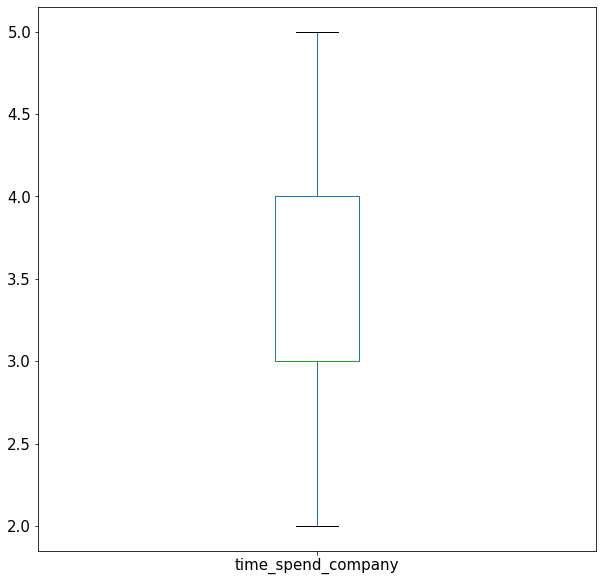

Analyzing outliers of column: satisfaction_level_bin
0 outliers removed


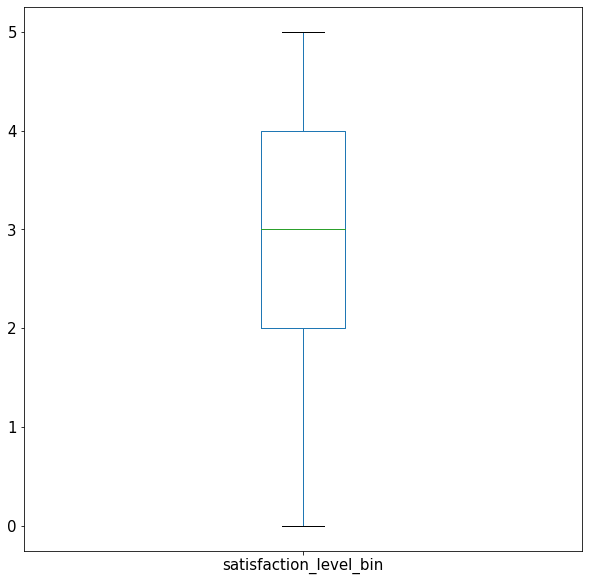

Analyzing outliers of column: last_evaluation_bin
3540 outliers removed


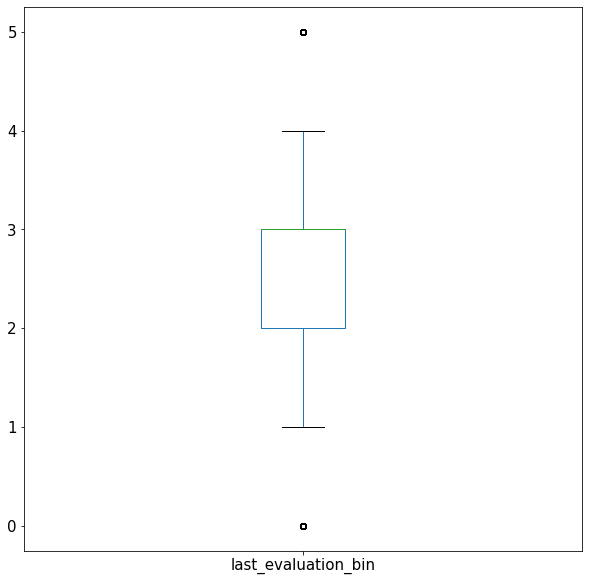

In [15]:
for (columnName, _) in hr_df.iteritems():
    if hr_df[columnName].dtype in ['int64','float64']: # IS numeric
        print("Analyzing outliers of column: {}".format(columnName))
        plt.figure(figsize=(10,10))
        hr_df.boxplot([columnName], grid=False, fontsize=15)
        hr_df = remove_outlier(hr_df,columnName)
        plt.show()
    

This way of identifying and removing the outliers is quite manual.

There are many procedures and libraries to perform this step in a more automatic fashion; e.g: https://machinelearningmastery.com/model-based-outlier-detection-and-removal-in-python/
No matter which way you decide to apply, please be careful with this process and closely monitore it to ensure that you do not remove any relevant data.

# Train-Test Splitting

We are going to split the annotated dataset in training and test for the later evaluation of our ML models. To that end, sklearn again provides a `train_test_split` function to do it.

As we have some categorical values with strings, we need to encode them for the application of the sklearn classifiers. There are several ways of performing this encoding step, I do recommend you to check the sklearn documentation, for more details.

https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-categorical-features

Another useful resource that you can check with code examples:

https://inria.github.io/scikit-learn-mooc/python_scripts/03_categorical_pipeline.html

Finally, the simplest one (and the one that I will use) is to leverage the [`get_dummies`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) function in pandas:

In [16]:
# Concat the dummified columns and the target variable
dummified_hr_df = pd.concat([
        pd.get_dummies(hr_df.drop(['left'], axis=1)).reset_index(drop=True),
        hr_df['left'].reset_index(drop=True)],
    axis=1)
dummified_hr_df.head(5)


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,satisfaction_level_bin,last_evaluation_bin,Work_accident_0,Work_accident_1,promotion_last_5years_0,...,salary_medium,number_project_cat_High,number_project_cat_Low,number_project_cat_Medium,number_project_cat_Very_High,time_spend_company_cat_High,time_spend_company_cat_Low,time_spend_company_cat_Medium,time_spend_company_cat_Very_High,left
0,0.38,0.53,2,157,3,2,2,1,0,1,...,0,0,1,0,0,0,0,1,0,1
1,0.11,0.88,7,272,4,0,3,1,0,1,...,1,0,0,0,1,0,0,1,0,1
2,0.72,0.87,5,223,5,4,3,1,0,1,...,0,0,0,1,0,0,0,1,0,1
3,0.37,0.52,2,159,3,2,2,1,0,1,...,0,0,1,0,0,0,0,1,0,1
4,0.41,0.50,2,153,3,2,2,1,0,1,...,0,0,1,0,0,0,0,1,0,1


Now the spliting. I am using 2/3 of the dataset for training and 1/3 for testing. There is no right spliting, but usually we use more data for training than for test, especially if you do not have so many data.

In the next lab session we will explore the idea of cross-validation so this decision will not be so important.

In [17]:
from sklearn.model_selection import train_test_split

# left is the target variable
X = dummified_hr_df.loc[:, dummified_hr_df.columns != 'left']
y = dummified_hr_df['left']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


# Feature Engineering

We first fit a linear model to the initial dataset to have a baseline to evaluate the impact of the data cleaning and feature engineering.

To facilitate the training process we will use the `sklearn` library <https://scikit-learn.org/stable/index.html> that provides a wrapper for the preprocessing, training and evaluation of many machine learning algorithms. 

In [18]:
from sklearn import linear_model
initial_lm_mod = linear_model.LogisticRegression(max_iter=1000, penalty='none')
initial_lm_mod.fit(X_train, y_train)

LogisticRegression(max_iter=1000, penalty='none')

Sklearn does not provide a handy way to plot the feature importance of the LogisticRegression models. We can work it out by extracting the values of the logreg coefficients. (Code taken from: https://stackoverflow.com/a/47191103)

In [19]:
def get_feature_importance(clf, feature_names):
    return pd.DataFrame({'variable': feature_names, # Feature names
                         'coefficient': clf.coef_[0] # Feature Coeficients
                    }) \
    .round(decimals=2) \
    .sort_values('coefficient', ascending=False) \
    .style.bar(color=['red', 'green'], align='zero')

In [20]:
get_feature_importance(initial_lm_mod, X_train.columns)

,variable,coefficient
27,number_project_cat_Very_High,8.960000
1,last_evaluation,3.620000
0,satisfaction_level,3.490000
7,Work_accident_0,1.930000
30,time_spend_company_cat_Medium,1.920000
9,promotion_last_5years_0,1.810000
24,number_project_cat_High,1.580000
22,salary_low,1.420000
23,salary_medium,1.120000
4,time_spend_company,0.780000


Accuracy = 0.9041


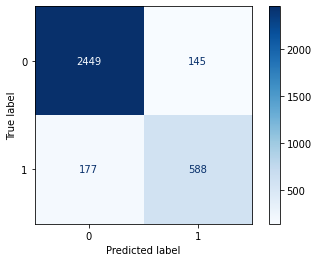

In [21]:
from sklearn.metrics import plot_confusion_matrix, accuracy_score

print("Accuracy = {0:.4f}".format(accuracy_score(y_test,initial_lm_mod.predict(X_test))))
plot_confusion_matrix(initial_lm_mod, X_test, y_test, y_test.unique(), cmap=plt.cm.Blues);


In [22]:
results_df = pd.DataFrame(columns=['Approach', 'Accuracy'])
results_df.loc[len(results_df)] = ['LR Baseline', accuracy_score(y_test,initial_lm_mod.predict(X_test))]
results_df

,Approach,Accuracy
0,LR Baseline,0.904138


The analysis of the confusion matrix points out some interesting aspects:
  
 - We have an accuracy close to 90%, which seems a good results to be reported to the HR department.
 
 - We are better at predicting the negative class (a employee is NOT going to leave the company) than the positive class (a employee is going to leave the company).

Note: The plot_confusion_matrix is only available in the newest sklearn versions (>=0.22). If you are running an older version you can use the following code:

```python
def plot_confusion_matrix(classifier, X_test, y_true, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    from sklearn.utils.multiclass import unique_labels
    from sklearn.metrics import confusion_matrix
    import numpy as np

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
            
    y_pred = classifier.predict(X_test)
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
```

## Filtering Methods


We will rank the features according to their predictive power by applying the methodologies seen in class: the Chi Squared Independence test and the Information Gain.

### Chi-squared Selection
Making use of the `SelectKBest` function rank the features according to the Chi Squared value. 

Does it make sense to remove some features? If so, do it!

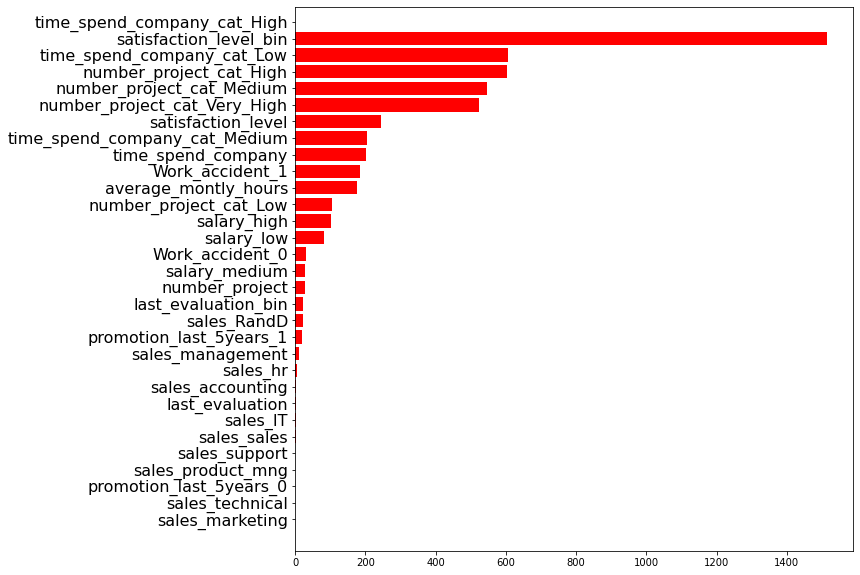

In [23]:
from sklearn.feature_selection import SelectKBest, chi2

chi2_selector = SelectKBest(score_func=chi2).fit(X,y)

# Get the indices sorted by most important to least important
indices = np.argsort(chi2_selector.scores_)[::-1]

chi2_features = []
for i in range(len(X.columns)):
    chi2_features.append(X.columns[indices[i]])

# Now plot
plt.figure(figsize=(10,10))
plt.yticks(rotation='horizontal',fontsize=16)
plt.barh(chi2_features, chi2_selector.scores_[indices[range(len(X.columns))]], color='r', align='center')
plt.gca().invert_yaxis()
plt.show()

We are going to find the optimal number of features to select

In [24]:
for i in range(1,len(chi2_features)):
    print("Features used to train the model = {}".format(i))
    print("Accuracy = {0:.4f}".format(accuracy_score(y_test,linear_model.LogisticRegression(max_iter=1000, penalty='none').fit(X_train[chi2_features[:i]], y_train).predict(X_test[chi2_features[:i]]))))
    print()


Features used to train the model = 1
Accuracy = 0.7723

Features used to train the model = 2
Accuracy = 0.7723

Features used to train the model = 3
Accuracy = 0.7734

Features used to train the model = 4
Accuracy = 0.7809

Features used to train the model = 5
Accuracy = 0.7809

Features used to train the model = 6
Accuracy = 0.9196

Features used to train the model = 7
Accuracy = 0.9196

Features used to train the model = 8
Accuracy = 0.9178

Features used to train the model = 9
Accuracy = 0.9178

Features used to train the model = 10
Accuracy = 0.8934

Features used to train the model = 11
Accuracy = 0.9062

Features used to train the model = 12
Accuracy = 0.9071

Features used to train the model = 13
Accuracy = 0.9068

Features used to train the model = 14
Accuracy = 0.9032

Features used to train the model = 15
Accuracy = 0.9032

Features used to train the model = 16
Accuracy = 0.9018

Features used to train the model = 17
Accuracy = 0.9026

Features used to train the model = 18
Ac

As you can see around 4-6 features we achieved our optimal model. Let's select the top 6 features

In [25]:
chi2_features[:6]

['time_spend_company_cat_Very_High',
 'time_spend_company_cat_High',
 'satisfaction_level_bin',
 'time_spend_company_cat_Low',
 'number_project_cat_High',
 'number_project_cat_Medium']

Train a new model using only the selected features and evaluate its performance

In [26]:
chi2_initial_lm_mod = linear_model.LogisticRegression(max_iter=1000, penalty='none')
chi2_initial_lm_mod.fit(X_train[chi2_features[:6]], y_train)

LogisticRegression(max_iter=1000, penalty='none')

In [27]:
get_feature_importance(chi2_initial_lm_mod, X_train[chi2_features[:6]].columns)

,variable,coefficient
0,time_spend_company_cat_Very_High,0.000000
1,time_spend_company_cat_High,0.000000
4,number_project_cat_High,-1.020000
2,satisfaction_level_bin,-1.100000
5,number_project_cat_Medium,-1.520000
3,time_spend_company_cat_Low,-2.630000


Accuracy = 0.9196


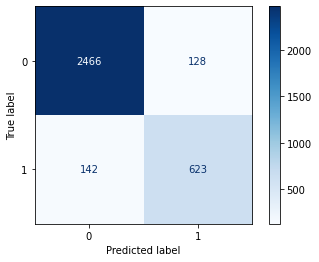

In [28]:
print("Accuracy = {0:.4f}".format(accuracy_score(y_test,chi2_initial_lm_mod.predict(X_test[chi2_features[:6]]))))
plot_confusion_matrix(chi2_initial_lm_mod, X_test[chi2_features[:6]], y_test, y_test.unique(), cmap=plt.cm.Blues);

As we discussed in class, these filtering techniques allow us to select the most important features in order to predict the target variable. By using less and more important features, we avoid the overfitting of the model, thus achieving better test performance.

In [29]:
results_df.loc[len(results_df)] = ['LR ChiSquared Selection', accuracy_score(y_test,chi2_initial_lm_mod.predict(X_test[chi2_features[:6]]))]
results_df

,Approach,Accuracy
0,LR Baseline,0.904138
1,LR ChiSquared Selection,0.919619


### Information Gain Selection

Repeat the same process to, making use of the SelectKBest function (or other you choice), rank the features according to the Information Gain value.

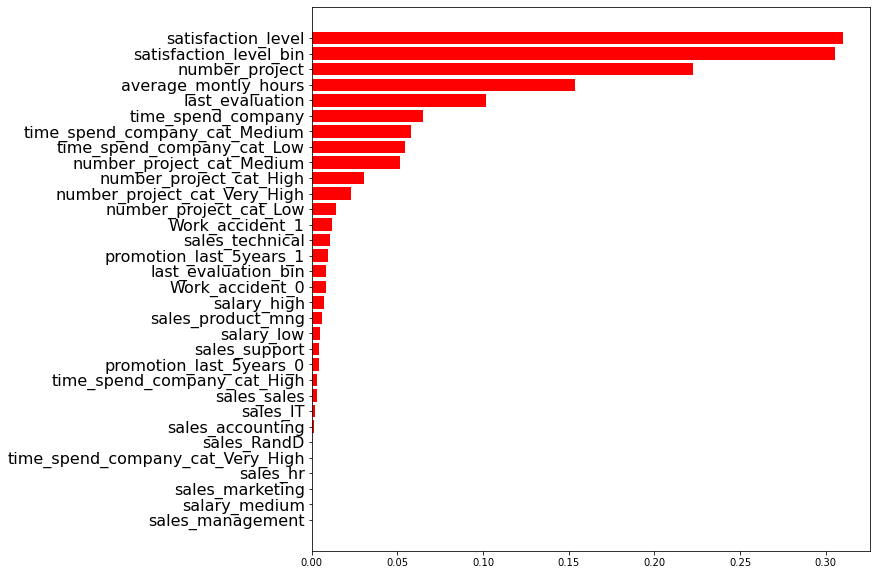

In [30]:
from sklearn.feature_selection import mutual_info_classif

ig_selector = SelectKBest(score_func=mutual_info_classif).fit(X,y)

# Get the indices sorted by most important to least important
indices = np.argsort(ig_selector.scores_)[::-1]

ig_features = []
for i in range(len(X.columns)):
    ig_features.append(X.columns[indices[i]])

# Now plot
plt.figure(figsize=(10,10))
plt.yticks(rotation='horizontal',fontsize=16)
plt.barh(ig_features, ig_selector.scores_[indices[range(len(X.columns))]], color='r', align='center')
plt.gca().invert_yaxis()
plt.show()

In [31]:
for i in range(1,len(ig_features)):
    print("Features used to train the model = {}".format(i))
    print("Accuracy = {0:.4f}".format(accuracy_score(y_test,linear_model.LogisticRegression(max_iter=1000, penalty='none').fit(X_train[ig_features[:i]], y_train).predict(X_test[ig_features[:i]]))))
    print()

Features used to train the model = 1
Accuracy = 0.7821

Features used to train the model = 2
Accuracy = 0.7734

Features used to train the model = 3
Accuracy = 0.9065

Features used to train the model = 4
Accuracy = 0.9083

Features used to train the model = 5
Accuracy = 0.9074

Features used to train the model = 6
Accuracy = 0.9018

Features used to train the model = 7
Accuracy = 0.9074

Features used to train the model = 8
Accuracy = 0.9074

Features used to train the model = 9
Accuracy = 0.9098

Features used to train the model = 10
Accuracy = 0.9095

Features used to train the model = 11
Accuracy = 0.9119

Features used to train the model = 12
Accuracy = 0.9122

Features used to train the model = 13
Accuracy = 0.9053

Features used to train the model = 14
Accuracy = 0.9059

Features used to train the model = 15
Accuracy = 0.9047

Features used to train the model = 16
Accuracy = 0.9083

Features used to train the model = 17
Accuracy = 0.9083

Features used to train the model = 18
Ac

It seems that the top performance is achieved by selecting the top 11 features according ot IG, let's use them

In [32]:
ig_features[:11]

['satisfaction_level',
 'satisfaction_level_bin',
 'number_project',
 'average_montly_hours',
 'last_evaluation',
 'time_spend_company',
 'time_spend_company_cat_Medium',
 'time_spend_company_cat_Low',
 'number_project_cat_Medium',
 'number_project_cat_High',
 'number_project_cat_Very_High']

In [33]:
ig_initial_lm_mod = linear_model.LogisticRegression(max_iter=1000, penalty='none')
ig_initial_lm_mod.fit(X_train[ig_features[:11]], y_train)

LogisticRegression(max_iter=1000, penalty='none')

In [34]:
get_feature_importance(ig_initial_lm_mod, X_train[ig_features[:11]].columns)

,variable,coefficient
10,number_project_cat_Very_High,14.140000
9,number_project_cat_High,6.910000
0,satisfaction_level,4.110000
8,number_project_cat_Medium,2.490000
6,time_spend_company_cat_Medium,2.070000
7,time_spend_company_cat_Low,0.750000
5,time_spend_company,0.730000
3,average_montly_hours,0.000000
4,last_evaluation,-0.650000
1,satisfaction_level_bin,-1.670000


Accuracy = 0.9119


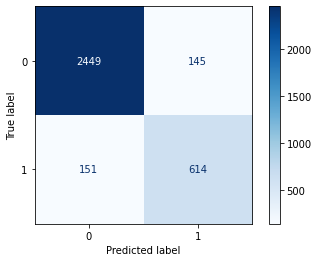

In [35]:
print("Accuracy = {0:.4f}".format(accuracy_score(y_test,ig_initial_lm_mod.predict(X_test[ig_features[:11]]))))
plot_confusion_matrix(ig_initial_lm_mod, X_test[ig_features[:11]], y_test, y_test.unique(), cmap=plt.cm.Blues);

In [36]:
results_df.loc[len(results_df)] = ['LR IG Selection', accuracy_score(y_test,ig_initial_lm_mod.predict(X_test[ig_features[:11]]))]
results_df

,Approach,Accuracy
0,LR Baseline,0.904138
1,LR ChiSquared Selection,0.919619
2,LR IG Selection,0.911879


Chi2-based performances is larger than IG-base, so in the following we will make use of this subset of features.

In [37]:
X_train = X_train[chi2_features[:6]]
X_test = X_test[chi2_features[:6]]

## Embedded

Finally, we will experiment with embedded methods. 

### Ridge

For this exercise, we are going to make use of the Ridge Model in sklearn <https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression-and-classification>

In [38]:
ridge_mod = linear_model.LogisticRegression(max_iter=10000,penalty='l2')
ridge_mod.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [39]:
get_feature_importance(ridge_mod, X_train.columns)

,variable,coefficient
0,time_spend_company_cat_Very_High,0.000000
1,time_spend_company_cat_High,0.000000
4,number_project_cat_High,-0.990000
2,satisfaction_level_bin,-1.090000
5,number_project_cat_Medium,-1.500000
3,time_spend_company_cat_Low,-2.530000


Accuracy = 0.9196


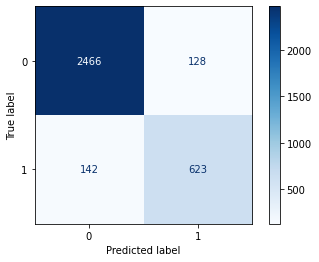

In [40]:
print("Accuracy = {0:.4f}".format(accuracy_score(y_test,ridge_mod.predict(X_test))))
plot_confusion_matrix(ridge_mod, X_test, y_test, y_test.unique(), cmap=plt.cm.Blues)

In [41]:
results_df.loc[len(results_df)] = ['LR Ridge', accuracy_score(y_test,ridge_mod.predict(X_test))]
results_df

,Approach,Accuracy
0,LR Baseline,0.904138
1,LR ChiSquared Selection,0.919619
2,LR IG Selection,0.911879
3,LR Ridge,0.919619


A small improvement w.r.t the un-regularized models.

Let's take a look at how the coefficient weights and accuracy scores change along the different alpha values.

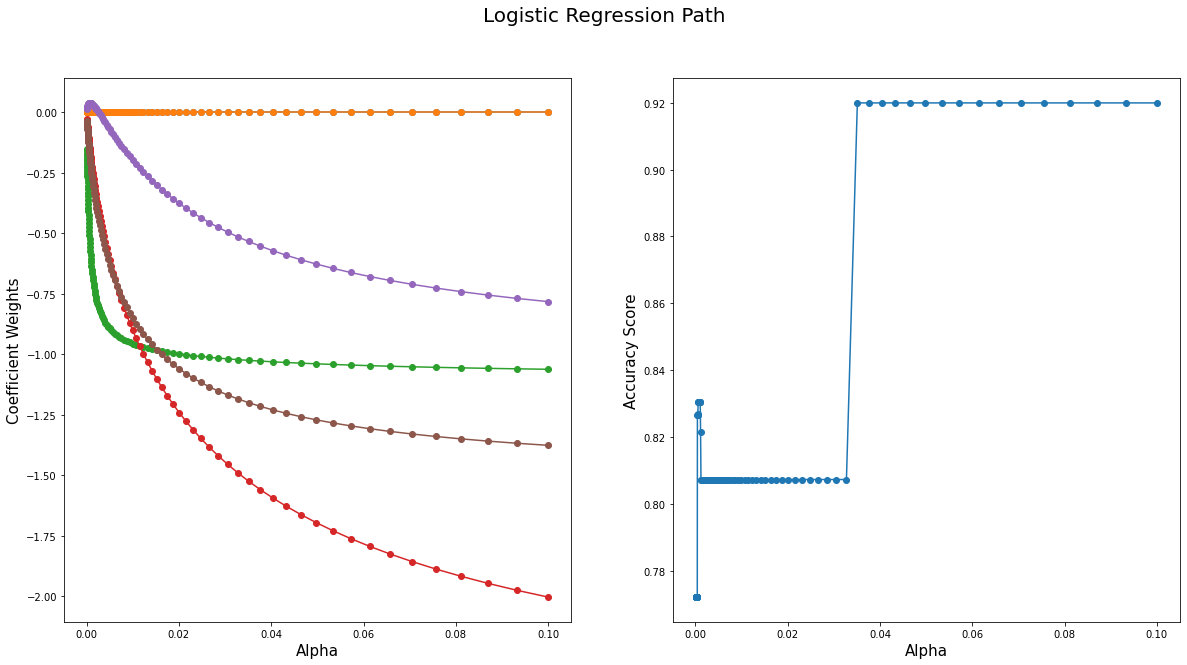

In [42]:
ridge_mod = linear_model.LogisticRegression(max_iter=10000,penalty='l2')
alphas = 10**np.linspace(-1,-4,100)

coefs_ = []
scores_ = []
for a in alphas:
    ridge_mod.set_params(C=a)
    ridge_mod.fit(X_train, y_train)
    coefs_.append(ridge_mod.coef_.ravel().copy())
    scores_.append(accuracy_score(y_test,ridge_mod.predict(X_test)))

coefs_ = np.array(coefs_)
scores_ = np.array(scores_)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle('Logistic Regression Path', fontsize=20)

# Coeff Weights Plot
ax1.plot(alphas, coefs_, marker='o')
ymin, ymax = plt.ylim()
ax1.set_ylabel('Coefficient Weights', fontsize = 15)
ax1.set_xlabel('Alpha', fontsize = 15)
ax1.axis('tight')

# Accuracy Plot
ax2.plot(alphas, scores_, marker='o')
ymin, ymax = plt.ylim()
ax2.set_ylabel('Accuracy Score', fontsize = 15)
ax2.set_xlabel('Alpha', fontsize = 15)
ax2.axis('tight')

plt.show()

As you can see in the left figure, the smaller the alpha value, the larger the regularization and, consequently, the smaller the weights of the coefficients. When regularization is large enough, the values of the coefficients are close to 0 (i.e., null model). As there is a trade-off between variance (i.e., less over-fitted model --> more regularization) and bias (i.e., learning more from the training set --> less regularization), Cross-validation should be use to find the optimal alpha value. As you can see in the right figure, this value is achieved with small alpha values (i.e., more regularization).

In particular, you can make use of the LogisticRegressionCV function in sklearn (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) that performs CV, testing different hyperparameters (that you can provide) and selecting the optimal one. 

In [43]:
from sklearn.feature_selection import SelectFromModel
alphas = 10**np.linspace(-1,-4,100)

ridge_mod_cv = linear_model.LogisticRegressionCV(max_iter=10000,penalty='l2',Cs=alphas).fit(X_train, y_train)

Accuracy = 0.9199


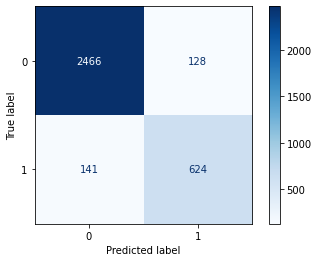

In [44]:
print("Accuracy = {0:.4f}".format(accuracy_score(y_test,ridge_mod_cv.predict(X_test))))
plot_confusion_matrix(ridge_mod_cv, X_test, y_test, y_test.unique(), cmap=plt.cm.Blues);

In [45]:
results_df.loc[len(results_df)] = ['LR CV Ridge', accuracy_score(y_test,ridge_mod_cv.predict(X_test))]
results_df

,Approach,Accuracy
0,LR Baseline,0.904138
1,LR ChiSquared Selection,0.919619
2,LR IG Selection,0.911879
3,LR Ridge,0.919619
4,LR CV Ridge,0.919917


We do not have many feature, so the optimization of the alpha values does not provide a huge improvement.

### Lasso

Let's see if Lasso (which actually removes features by making their coefficients equal to 0) improves the unregularized model.

In [46]:
lasso_mod = linear_model.LogisticRegression(penalty='l1', solver='liblinear')
lasso_mod.fit(X_train, y_train)

LogisticRegression(penalty='l1', solver='liblinear')

In [47]:
get_feature_importance(lasso_mod, X_train.columns)

,variable,coefficient
0,time_spend_company_cat_Very_High,0.000000
1,time_spend_company_cat_High,0.000000
4,number_project_cat_High,-0.980000
2,satisfaction_level_bin,-1.090000
5,number_project_cat_Medium,-1.500000
3,time_spend_company_cat_Low,-2.590000


Accuracy = 0.9196


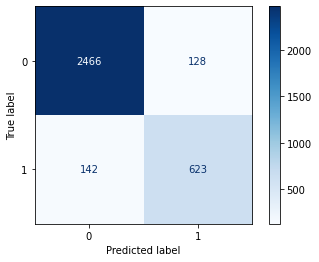

In [48]:
print("Accuracy = {0:.4f}".format(accuracy_score(y_test,lasso_mod.predict(X_test))))
plot_confusion_matrix(lasso_mod, X_test, y_test, y_test.unique(), cmap=plt.cm.Blues);

In [49]:
results_df.loc[len(results_df)] = ['LR Lasso', accuracy_score(y_test,lasso_mod.predict(X_test))]
results_df

,Approach,Accuracy
0,LR Baseline,0.904138
1,LR ChiSquared Selection,0.919619
2,LR IG Selection,0.911879
3,LR Ridge,0.919619
4,LR CV Ridge,0.919917
5,LR Lasso,0.919619


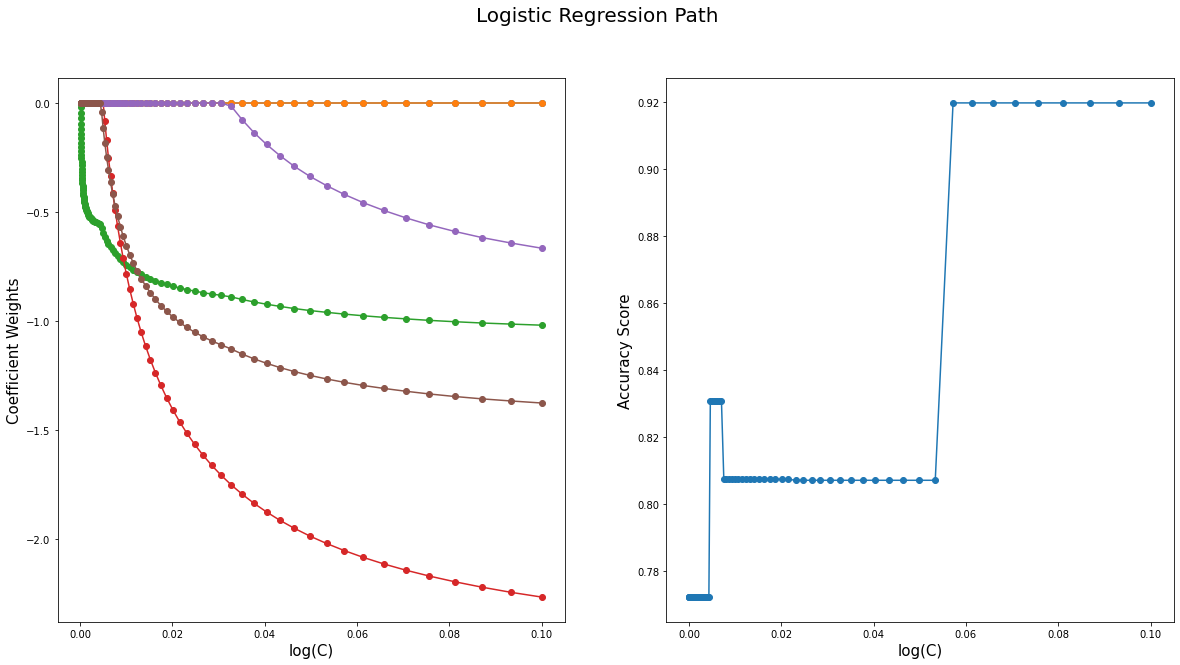

In [50]:
lasso_mod = linear_model.LogisticRegression(penalty='l1',solver='liblinear')
alphas = 10**np.linspace(-1,-4,100)

coefs_ = []
scores_ = []
for a in alphas:
    lasso_mod.set_params(C=a)
    lasso_mod.fit(X_train, y_train)
    coefs_.append(lasso_mod.coef_.ravel().copy())
    scores_.append(accuracy_score(y_test,lasso_mod.predict(X_test)))

coefs_ = np.array(coefs_)
scores_ = np.array(scores_)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle('Logistic Regression Path', fontsize=20)

# Coeff Weights Plot
ax1.plot(alphas, coefs_, marker='o')
ymin, ymax = plt.ylim()
ax1.set_ylabel('Coefficient Weights', fontsize = 15)
ax1.set_xlabel('log(C)', fontsize = 15)
ax1.axis('tight')

# Accuracy Plot
ax2.plot(alphas, scores_, marker='o')
ymin, ymax = plt.ylim()
ax2.set_ylabel('Accuracy Score', fontsize = 15)
ax2.set_xlabel('log(C)', fontsize = 15)
ax2.axis('tight')

plt.show()

As can be seen in both graphs, Lasso regularization is more abrupt. If you remember from class, Lasso tries to nullify the coefficients (Ridge only tries to smooth their values). As a consequence, when regularization is large enough, many coefficient values are close to 0. You should be very careful when applying this regularization. If the regularization parameter is too much restrictive, you are going to remove most of your features, and consequently, you'll ruin the performance of your model (as you can check in the right figure).

As with Rigde, you can use CV to find the optimal alpha value.

In [51]:
from sklearn.feature_selection import SelectFromModel

lasso_mod_cv = linear_model.LogisticRegressionCV(max_iter=10000,penalty='l1',solver='liblinear',Cs=alphas).fit(X_train, y_train)

Accuracy = 0.9196


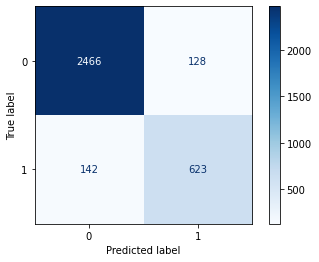

In [52]:
print("Accuracy = {0:.4f}".format(accuracy_score(y_test,lasso_mod_cv.predict(X_test))))
plot_confusion_matrix(lasso_mod_cv, X_test, y_test, y_test.unique(), cmap=plt.cm.Blues);

In [53]:
results_df.loc[len(results_df)] = ['LR CV Lasso', accuracy_score(y_test,lasso_mod_cv.predict(X_test))]
results_df

,Approach,Accuracy
0,LR Baseline,0.904138
1,LR ChiSquared Selection,0.919619
2,LR IG Selection,0.911879
3,LR Ridge,0.919619
4,LR CV Ridge,0.919917
5,LR Lasso,0.919619
6,LR CV Lasso,0.919619


The performance is the same than with Ridge

Since Lasso is actually performing Feature Selection (i.e., it nullifies/removes unimportant features) you can apply the trained model to transform your dataset to keep only the features selected by Lasso

In [54]:
model = SelectFromModel(lasso_mod_cv, prefit=True)
X_new = model.transform(X_train)
X_test_new = model.transform(X_test)
print("Original Number of Features = {} --> Number of features selected by Lasso = {}".format(X_train.shape[1], X_new.shape[1]))

Original Number of Features = 6 --> Number of features selected by Lasso = 4


Lasso is only removing 1 feature since we did remove many features in the ChiSquared selection. It explains why the results of both Lasso and Ridge are so similar.

Let's train a new model by just using these features.

Accuracy = 0.9196


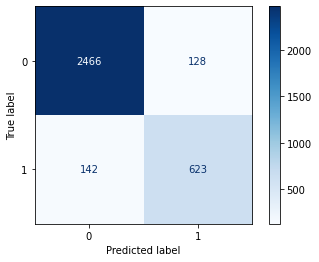

In [55]:
reduced_lasso_mod = linear_model.LogisticRegression(max_iter=10000,penalty='l1', solver='liblinear')
reduced_lasso_mod.fit(X_new, y_train)
print("Accuracy = {0:.4f}".format(accuracy_score(y_test,reduced_lasso_mod.predict(X_test_new))))
plot_confusion_matrix(reduced_lasso_mod, X_test_new, y_test, y_test.unique(), cmap=plt.cm.Blues);

In [56]:
results_df.loc[len(results_df)] = ['LR Reduced Lasso', accuracy_score(y_test,reduced_lasso_mod.predict(X_test_new))]
results_df

,Approach,Accuracy
0,LR Baseline,0.904138
1,LR ChiSquared Selection,0.919619
2,LR IG Selection,0.911879
3,LR Ridge,0.919619
4,LR CV Ridge,0.919917
5,LR Lasso,0.919619
6,LR CV Lasso,0.919619
7,LR Reduced Lasso,0.919619


In [57]:
get_feature_importance(reduced_lasso_mod, X_train.columns[model.get_support()])

,variable,coefficient
2,number_project_cat_High,-0.980000
0,satisfaction_level_bin,-1.090000
3,number_project_cat_Medium,-1.500000
1,time_spend_company_cat_Low,-2.590000


Performance is quite similar, however, we have achieved it with almost half the features than with the original model. As discussed many times, models using less features are preferable: less complexity, less computation time, more explainable and less prone to over-fitting.